In [1]:
import sys
sys.path.append('..')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
from skimage import io, img_as_ubyte
import json
import copy
from scipy.ndimage import gaussian_filter1d
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import torch
import torch.nn.functional as F
from torch.nn.utils import prune

import seaborn as sns
sns.set()

from models import get_net
from utils.denoising_utils import *
from utils.common_utils import np_to_pil, pil_to_np, get_fname

from BayTorch.freq_to_bayes import MCDropoutVI, MeanFieldVI
from BayTorch.inference.losses import uceloss
from BayTorch.inference.utils import uncert_regression_gal, prune_weights_ffg, prune_weights
import BayTorch.visualize as V

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{bm}']

In [2]:
def np_plot(xs, ys, labels=None, sigma=5, xlabel=r'iteration', ylabel='', xtlf='', ytlf='', 
            ylim=None, xlim=None, path=None, separate_legend=False, legend_cols=5):
    if labels is None:
        labels = ['' for _ in range(len(xs))]
    
    fig, ax = plt.subplots(1, 1)
    handles = []
    for x, y, l in zip(xs, ys, labels):
        if sigma > 0:
            y = gaussian_filter1d(y, sigma=sigma)
        plot = ax.plot(x, y, label=l)
        handles.append(plot[0])
    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if ylim != None:
        ax.set_ylim(ylim[0],ylim[1])
    if xlim != None:
        ax.set_xlim(xlim[0],xlim[1])
    ax.grid(True)
    if labels is not None and not separate_legend:
        ax.legend()
    
    if xtlf == 'sci':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
    if ytlf == 'sci':
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
    plt.tight_layout()
    if path is not None:
        plt.savefig(path)
    plt.show()
    if labels is not None and separate_legend:
        fig_l, ax_l = plt.subplots(1, 1)
        legend = ax_l.legend(handles, labels, loc='center', ncol=legend_cols)
        ax_l.grid(False)
        ax_l.set_yticks([])
        ax_l.set_xticks([])
        ax_l.set_facecolor((1., 1., 1.))
        fig_l  = legend.figure
        fig_l.canvas.draw()
        bbox  = legend.get_window_extent()
        bbox = bbox.from_extents(*(bbox.extents + np.array([-5,-5,5,5])))
        bbox = bbox.transformed(fig_l.dpi_scale_trans.inverted())
        if path is not None:
            fig_l.savefig('%s_legend.pdf' % path, dpi="figure", bbox_inches=bbox)
        plt.show()

In [3]:
def get_trained_net(net_info, train_data):
    bay_inf_type = net_info['bay_inf_type']
    
    net = get_net(net_info['num_input_channels'], 'skip', 'reflection',
              skip_n33d=net_info['num_channels_down'],
              skip_n33u=net_info['num_channels_up'],
              skip_n11=net_info['num_channels_skip'],
              num_scales=net_info['num_scales'],
              n_channels=net_info['num_output_channels'],
              upsample_mode=net_info['upsample_mode'],
              need_sigmoid=False)

    #optimizer = torch.optim.AdamW(net.parameters(), lr=net_info['lr'])
    
    if bay_inf_type == 'mc_dropout':
        net = MCDropoutVI(net, net_info['dropout_type'], net_info['dropout_p'])
    elif bay_inf_type == 'mean_field':
        prior = {'mu': net_info['prior_mu'], 'sigma': net_info['prior_sigma']}
        if net_info['prior_pi'] is not None:
            prior['pi'] = net_info['prior_pi']
        net = MeanFieldVI(net, prior=prior, kl_type=net_info['kl_type'])
    
    net.load_state_dict(train_data['state_dict'])
    return net.type(dtype)

In [4]:
#path_log_dir = '/home/toelle/logs'
path_log_dir = '/media/fastdata/toelle/logs'

#runs = [
#    'mean_field_den_10_19_2020_16_10_32',
#    'mean_field_den_10_21_2020_03_16_00', 'mean_field_den_10_21_2020_13_27_47', 
#        'mean_field_den_10_22_2020_03_56_57', 
#    'mc_dropout_den_10_22_2020_19_55_42',
#        #'none_den_10_22_2020_22_17_14', 
#    'sgld_den_10_22_2020_23_43_29',
#        #'sgld_paper_den_10_23_2020_03_36_28', 'sgld_paper_den_10_23_2020_02_20_33'
#]
#labels = [r'Gaussian Prior, forward KL', r'Gaussian Prior, no KL', 
#          r'Scale Mixture Prior, reverse KL', r'Scale Mixture Prior, forward KL', 
#          r'MCD, 2D', r'DIP MSE', r'SGLD MSE', r'SGLD paper MSE', r'SGLD paper NLL']

to_compare = 'oct_praesi'

if to_compare == 'dropout_ps':
    # dropout ps
    run = 'mc_dropout_den_xray_2d_p'
    runs = ['%s_01' % run, '%s_02' % run, 'mc_dropout_den_xray_2d_1', '%s_04' % run, '%s_05' % run, 
            '%s_07' % run, '%s_09' % run]
    label = 'MCD 2D'
    labels = ['%s 0.1' % label, '%s 0.2' % label, '%s 0.3' % label, '%s 0.4' % label, '%s 0.5' % label, 
              '%s 0.7' % label, '%s 0.9' % label]

elif to_compare == 'ffg_params':
    runs = ['none_den_xray_mcd_specs', 'mean_field_den_xray_1e-6_reverse_2', 'mean_field_den_xray_half_params']
    labels = ['DIP', 'FFG', 'FFG half']

elif to_compare == 'xray_praesi':
    runs = ['none_den_xray_mcd_specs', 
            'mean_field_den_xray_1e-6_reverse_2', 
            'mc_dropout_den_xray_2d_1',
            'sgld_den_xray_uncert',
            'sgld_paper_den_xray_uncert'
           ]
            #'sgld_den_xray_mse_mcd_specs', 'sgld_den_xray_nll_mcd_specs', 'sgld_paper_den_xray_mcd_specs',
            #'sgld_paper_den_xray_nll_mcd_specs'] # xray sgld den mcd specs mse
    labels = [r'DIP', r'FFG GP',
              r'MCD 2D', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+MSE $\sigma=\eta$']

elif to_compare == 'us_praesi':
    # compare all us
    runs = ['none_den_us_mcd_specs', 
            'mean_field_den_us_1e-6_reverse_2',
            'mc_dropout_den_us_2d_1',
            'sgld_den_us_uncert',
            'sgld_paper_den_us_uncert'
            #'sgld_den_us_mse_mcd_specs', 'sgld_den_us_nll_mcd_specs', 'sgld_paper_den_us_mcd_specs',
            #'sgld_paper_den_us_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', 
              r'MCD 2D', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+MSE $\sigma=\eta$']

elif to_compare == 'oct_praesi':
    # compare all oct
    runs = ['none_den_oct_mcd_specs', 
            'mean_field_den_oct_1e-6_reverse_2', 
            'mc_dropout_den_oct_2d_1', 
            'sgld_den_oct_uncert',
            'sgld_paper_den_oct_uncert'
            #'sgld_den_oct_mse_mcd_specs', 'sgld_den_oct_nll_mcd_specs', 'sgld_paper_den_oct_mcd_specs',
            #'sgld_paper_den_oct_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', 
              r'MCD 2D', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+MSE $\sigma=\eta$']
    
elif to_compare == 'kl_weights':
    # kl weights
    runs = ['mean_field_den_xray_standard_reverse', 'mean_field_den_xray_blundell_reverse', 
            'mean_field_den_xray_linear_reverse', 'mean_field_den_xray_no_params_reverse',
            #'mean_field_den_xray_soenderby_reverse', 
            'mean_field_den_xray_1e-2_reverse',
            'mean_field_den_xray_1e-4_reverse', 'mean_field_den_xray_1e-6_reverse_2',
            'mean_field_den_xray_1e-8_reverse', 'mean_field_den_xray_0']
    labels = [r'Standard', r'Blundell', r'Linear', r'No. params', #r'Soenderby', 
              r'$1e-2$', r'$1e-4$', r'$1e-6$', r'$1e-8$', r'$0$']

elif to_compare == 'xray':
    # compare all xray
    runs = ['none_den_xray_mcd_specs', 
            'mean_field_den_xray_1e-6_reverse_2', 'mean_field_den_xray_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_xray_2d_1', 'mc_dropout_den_xray_g2d_1',
            'sgld_den_xray_uncert', 'sgld_den_xray_nll_uncert_1',
            'sgld_paper_den_xray_uncert', 'sgld_paper_den_xray_nll_uncert_2'
           ]
            #'sgld_den_xray_mse_mcd_specs', 'sgld_den_xray_nll_mcd_specs', 'sgld_paper_den_xray_mcd_specs',
            #'sgld_paper_den_xray_nll_mcd_specs'] # xray sgld den mcd specs mse
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2D', r'MCD G2D', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']

elif to_compare == 'us':
    # compare all us
    runs = ['none_den_us_mcd_specs', 
            'mean_field_den_us_1e-6_reverse_2', 'mean_field_den_us_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_us_2d_1', 'mc_dropout_den_us_g2d_1', 
            'sgld_den_us_uncert', 'sgld_den_us_nll_uncert',
            'sgld_paper_den_us_uncert', 'sgld_paper_den_us_nll_uncert'
            #'sgld_den_us_mse_mcd_specs', 'sgld_den_us_nll_mcd_specs', 'sgld_paper_den_us_mcd_specs',
            #'sgld_paper_den_us_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2D', r'MCD G2D', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']


elif to_compare == 'oct':
    # compare all oct
    runs = ['none_den_oct_mcd_specs', 
            'mean_field_den_oct_1e-6_reverse_2', 'mean_field_den_oct_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_oct_2d_1', 'mc_dropout_den_oct_g2d_1', 
            'sgld_den_oct_uncert', 'sgld_den_oct_nll_uncert',
            'sgld_paper_den_oct_uncert', 'sgld_paper_den_oct_nll_uncert'
            #'sgld_den_oct_mse_mcd_specs', 'sgld_den_oct_nll_mcd_specs', 'sgld_paper_den_oct_mcd_specs',
            #'sgld_paper_den_oct_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2D', r'MCD G2D', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']


elif to_compare == 'mri':
    # compare all mri
    runs = ['none_den_mri_mcd_specs', 
            'mean_field_den_mri_1e-6_reverse_1', 'mean_field_den_mri_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_mri_2d_1', 'mc_dropout_den_mri_g2d_1', 
            'sgld_den_mri_uncert', 'sgld_den_mri_nll_uncert',
            'sgld_paper_den_mri_uncert', 'sgld_paper_den_mri_nll_uncert'
            #'sgld_den_mri_mse_mcd_specs', 'sgld_den_mri_nll_mcd_specs', 'sgld_paper_den_mri_mcd_specs',
            #'sgld_paper_den_mri_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2D', r'MCD G2D', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']


elif to_compare == 'ct':
    # compare all ct
    runs = ['none_den_ct_mcd_specs', 
            'mean_field_den_ct_1e-6_reverse_1', 'mean_field_den_ct_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_ct_2d_1', 'mc_dropout_den_ct_g2d_1', 
            'sgld_den_ct_uncert', 'sgld_den_ct_nll_uncert',
            'sgld_paper_den_ct_uncert', 'sgld_paper_den_ct_nll_uncert'
            #'sgld_den_ct_mse_mcd_specs', 'sgld_den_ct_nll_mcd_specs', 'sgld_paper_den_ct_mcd_specs',
            #'sgld_paper_den_ct_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2D', r'MCD G2D', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']


# smp
elif to_compare == 'smp':
    runs = ['mean_field_den_xray_1e-6_forward_smp_100_0001_02_08', 'mean_field_den_xray_1e-6_forward_smp_100_0001_04_06',
           'mean_field_den_xray_1e-6_forward_smp_100_0001_05_05', 'mean_field_den_xray_1e-6_forward_smp_100_0001_06_04',
           'mean_field_den_xray_1e-6_forward_smp_100_0001_08_02']
    labels = [r'$\pi_1=0.2$, $\pi_2=0.8$', r'$\pi_1=0.4$, $\pi_2=0.6$', 
              r'$\pi_1=0.5$, $\pi_2=0.5$', r'$\pi_1=0.6$, $\pi_2=0.4$',
             r'$\pi_1=0.8$, $\pi_2=0.2$']


elif to_compare == 'sigmas':
    # sigmas
    run = 'mean_field_den_xray_1e-6_reverse_sigma'
    runs = ['%s_001' % run, '%s_005' % run, 'mean_field_den_xray_1e-6_reverse_2', '%s_015' % run, '%s_02' % run, 
            '%s_025' % run, '%s_05' % run]
    labels = [r'$\sigma = 0.01$', r'$\sigma = 0.05$', r'$\sigma = 0.1$', r'$\sigma = 0.15$', r'$\sigma = 0.2$', 
              r'$\sigma = 0.25$', r'$\sigma = 0.5$']

# reverse / forward


# reverse / forward smp


# sgld

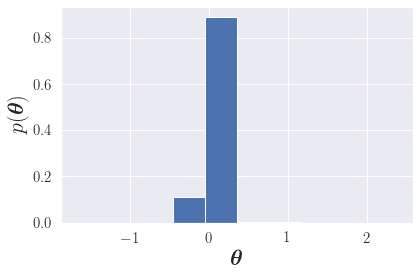

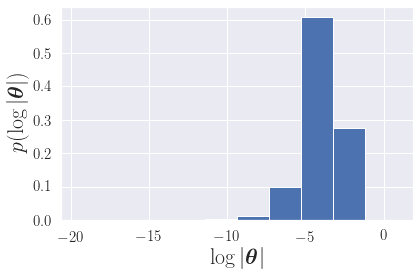

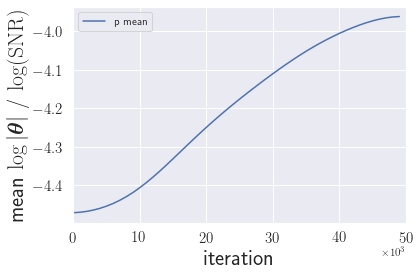

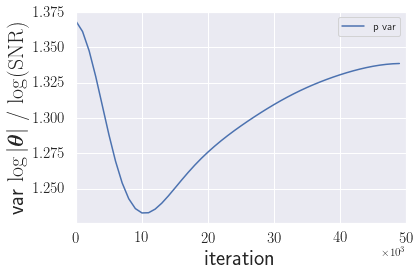

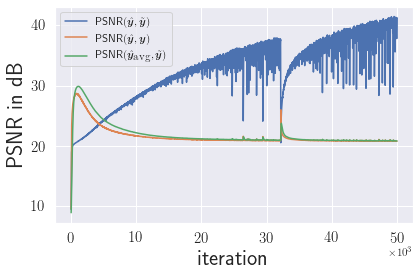

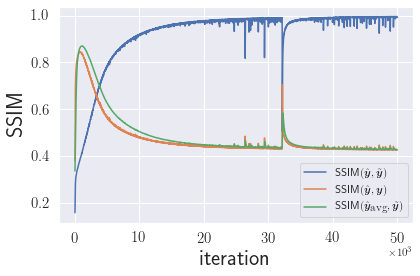

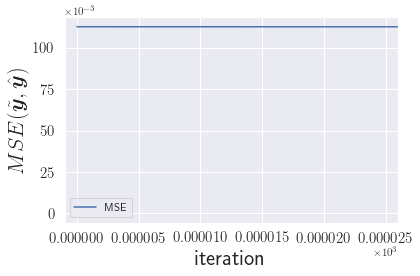

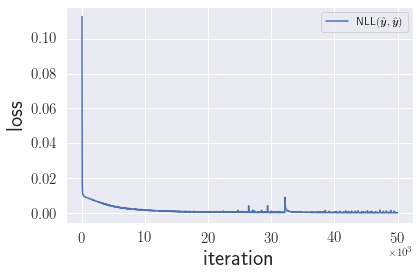

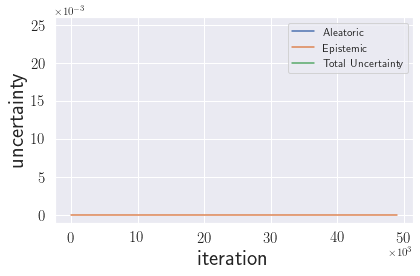

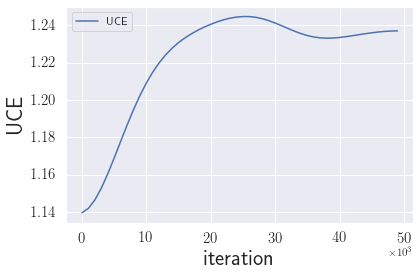

/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


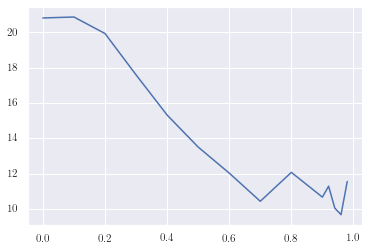

Number of params: 2217702


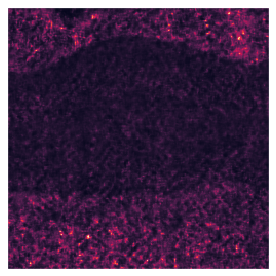

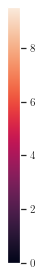

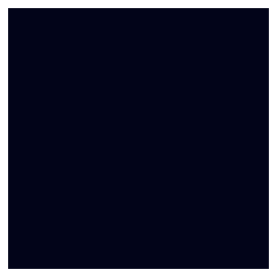

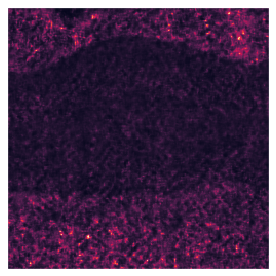

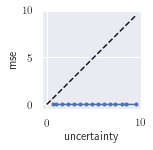

/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


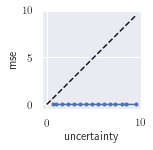

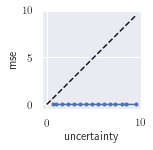

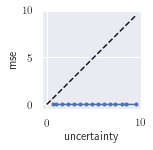

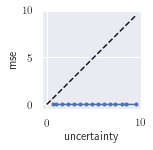

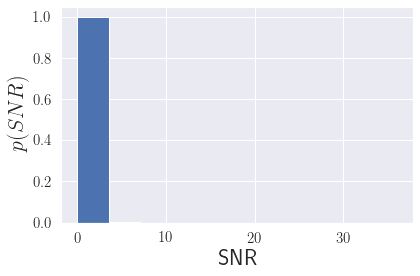

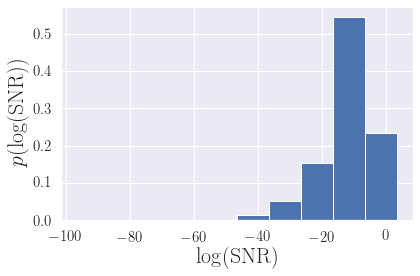

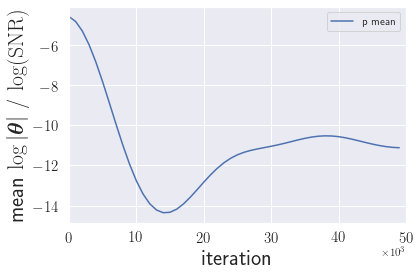

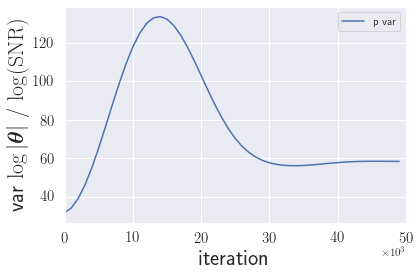

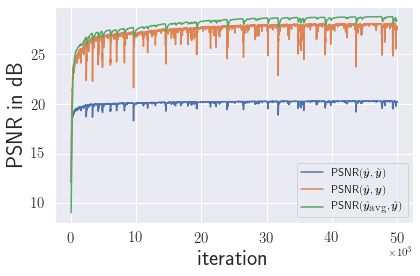

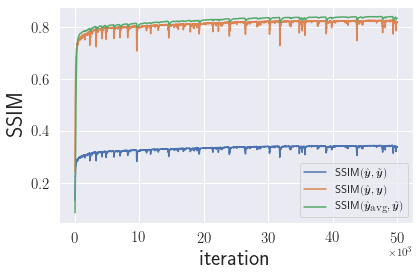

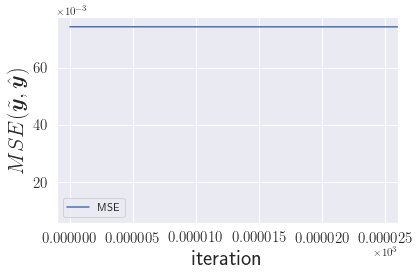

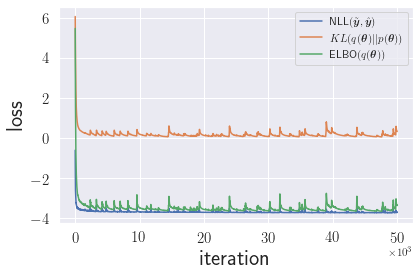

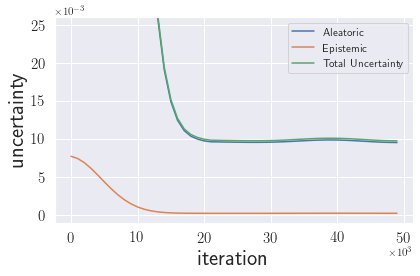

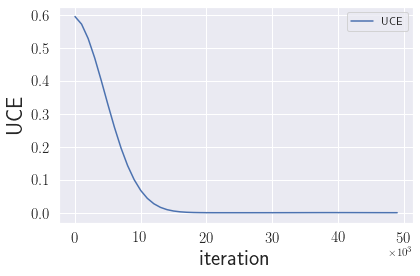

/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
../BayTorch/inference/utils.py:118: RuntimeWarning: divide by zero encountered in log
  snrs = np.hstack((snrs, np.log(snr_np)))


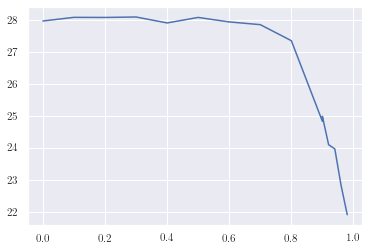

Number of params: 4428924


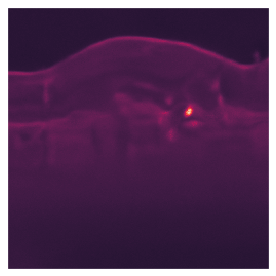

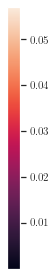

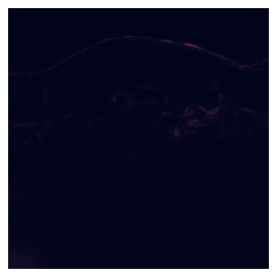

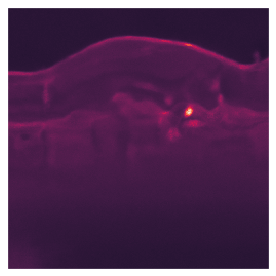

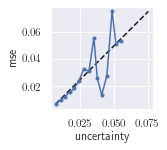

/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


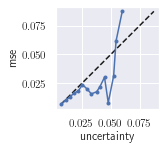

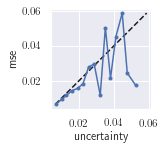

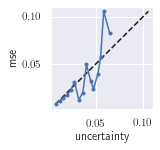

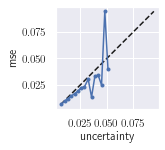

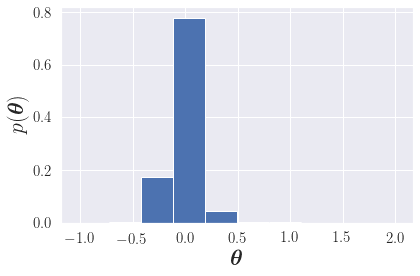

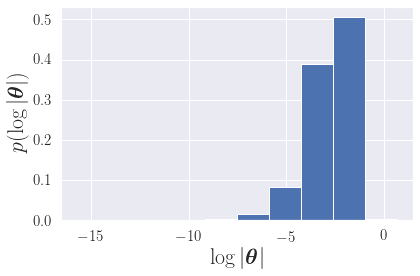

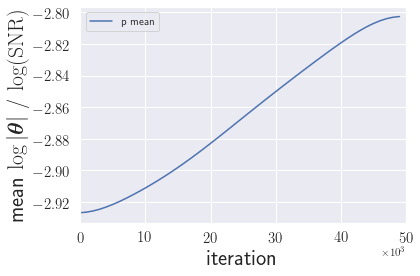

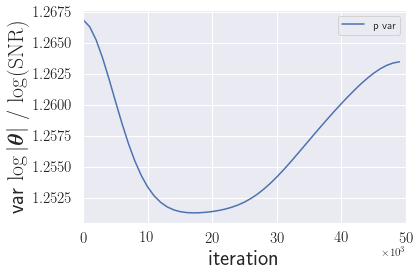

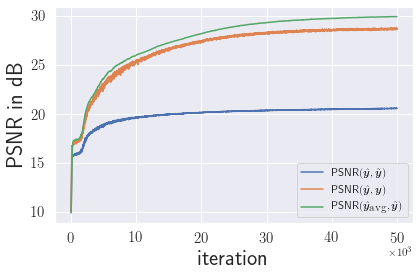

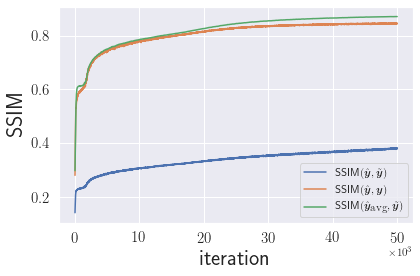

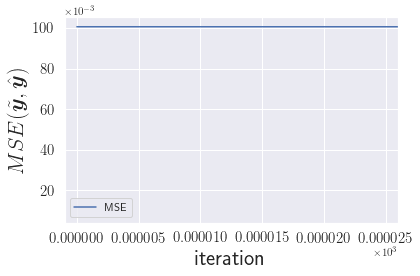

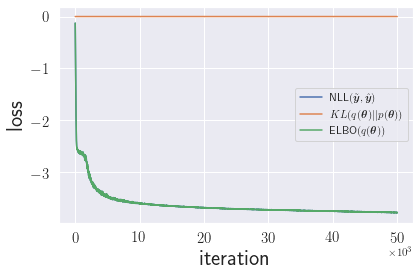

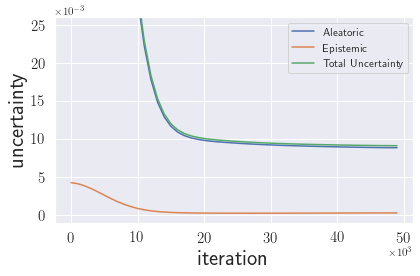

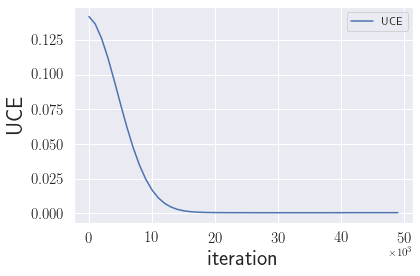

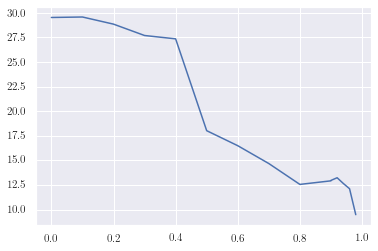

Number of params: 2217702


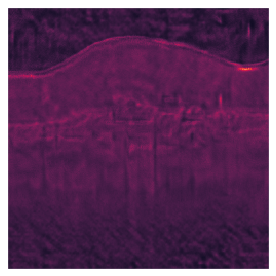

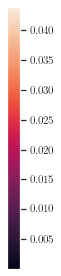

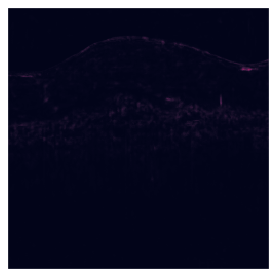

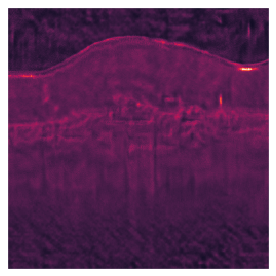

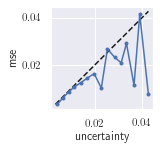

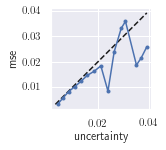

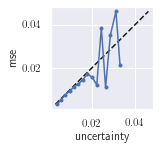

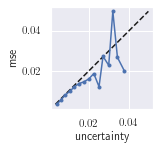

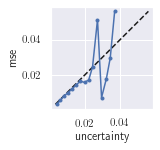

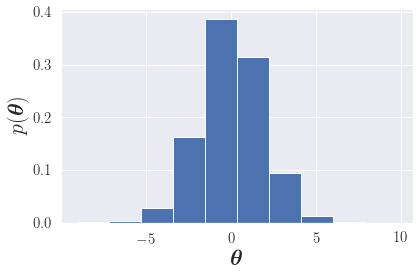

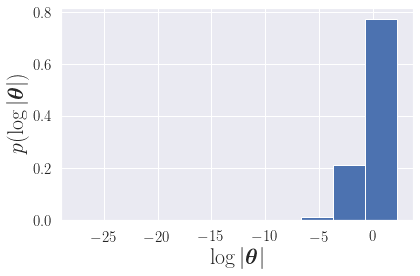

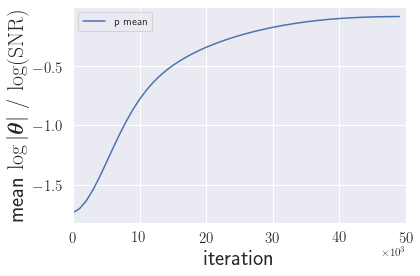

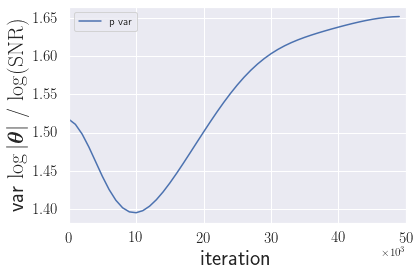

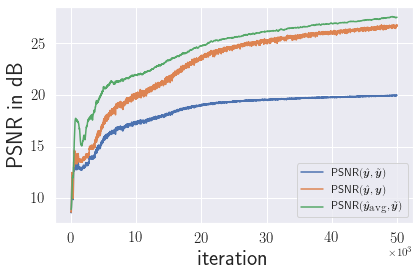

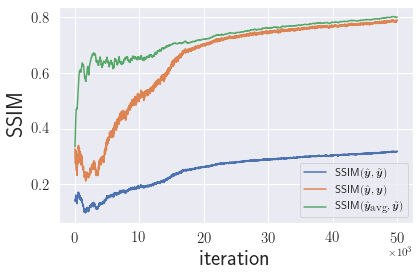

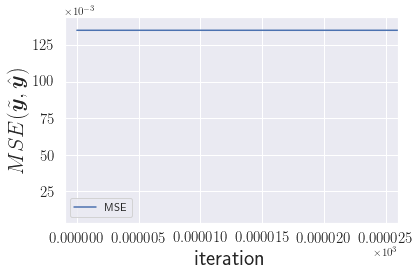

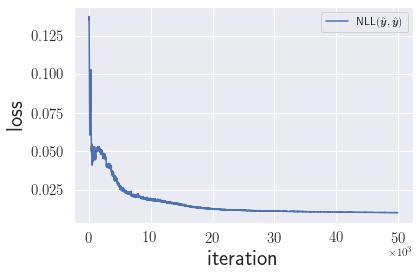

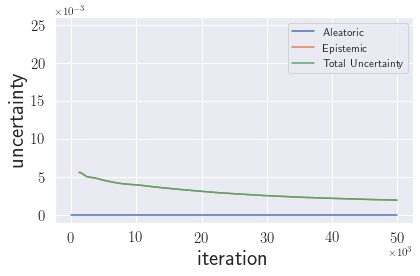

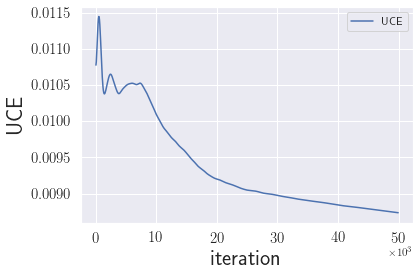

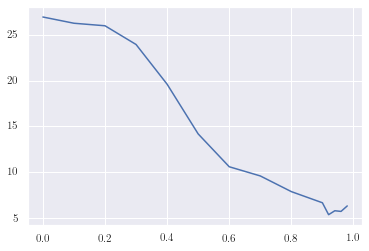

Number of params: 2217702


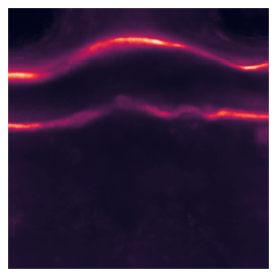

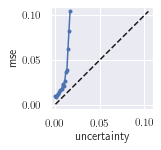

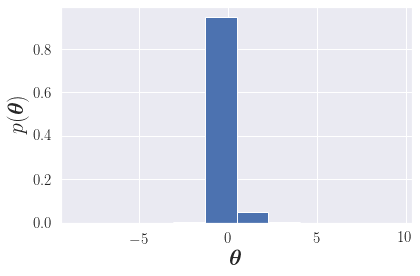

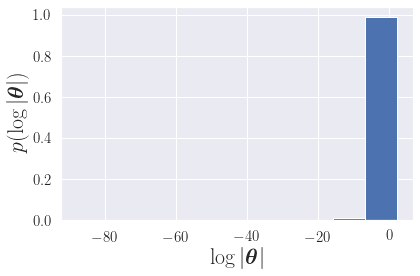

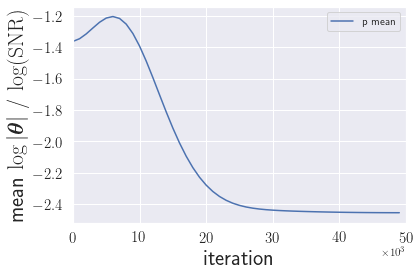

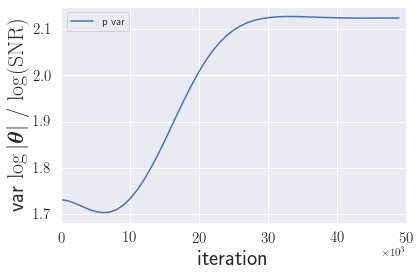

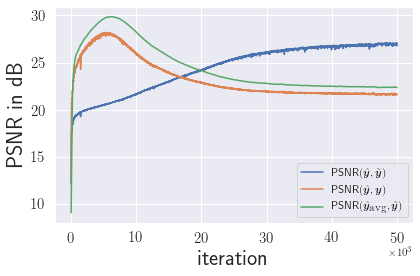

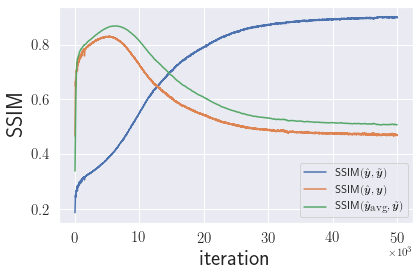

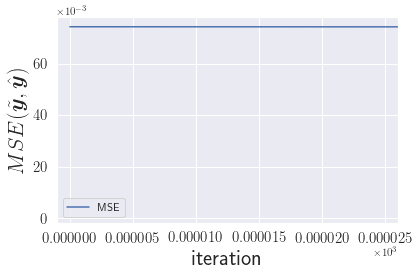

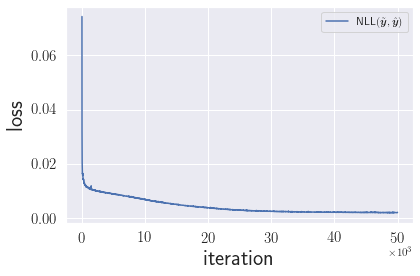

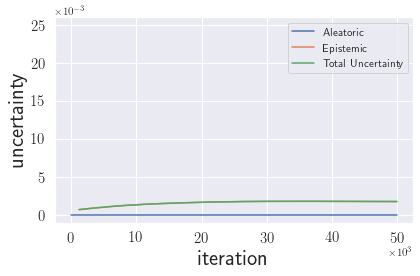

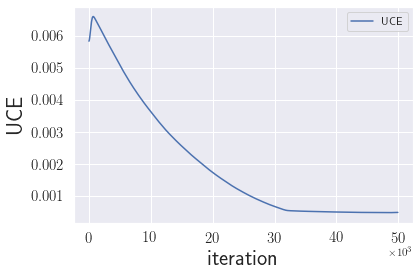

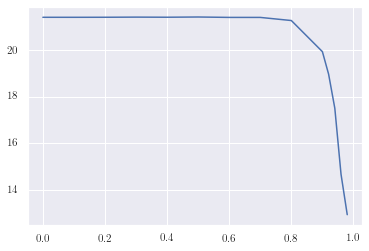

Number of params: 2217702


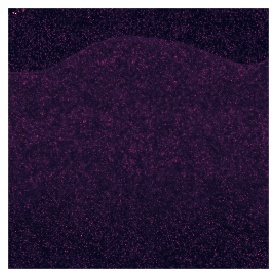

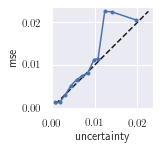

In [5]:
pruning_range = np.hstack((np.arange(0.,1.,0.1), np.arange(0.9, 1., 0.02)))
pruning = True

mc_iter = 10

losses = {}
psnrs = {}
ssims = {}
uncerts = {}
uces = {}
params = {}

ale_maps = []
epi_maps = []
uncert_maps = []

for run, label in zip(runs, labels):
    train_data = torch.load('%s/%s/train_vals.pt' % (path_log_dir, run))
    net_info = json.load(open('%s/%s/net_info.json' % (path_log_dir, run)))
    image_data = np.load('%s/%s/vals.npz' % (path_log_dir, run))
    img_np_noisy = pil_to_np(Image.open('%s/%s/noisy_img.png' % (path_log_dir, run)))
    
    bay_inf_type = net_info['bay_inf_type']
    
    fname = get_fname(image_data['img_name'])
    img_pil = crop_image(get_image(fname, -1)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    if run[:4] in ['sgld', 'none']:
        losses[run] = {'mse': train_data['mse'], 'nll': train_data['nll'], 'kl': np.zeros(len(train_data['nll'])), 'elbo': train_data['nll']}
    else:
        losses[run] = {'mse': train_data['mse'], 'nll': train_data['nll'], 'kl': train_data['kl'], 'elbo': train_data['elbo']}
    psnrs[run] = {'noisy': train_data['psnr_noisy'], 'gt': train_data['psnr_gt'], 'gt\_sm': train_data['psnr_gt_sm']}
    ssims[run] = {'noisy': train_data['ssim_noisy'], 'gt': train_data['ssim_gt'], 'gt\_sm': train_data['ssim_gt_sm']}
    uncerts[run] = {'ale': train_data['ale'], 'epi': train_data['epi'], 'uncert': train_data['uncert'], 
                    'uce': [y.item() for y in train_data['uce']], 'err_in_bin': train_data['err_in_bin'], 
                    'avg_sigma_in_bin': train_data['avg_sigma_in_bin'], 'freq_in_bin': train_data['freq_in_bin']}
    
    if bay_inf_type == 'mean_field':
        V.snr_hist(mus=train_data['params_mu'][-1], sigmas=train_data['params_sigma'][-1], path='imgs/%s_snr_hist.pdf' % run)
        V.log_snr_hist(mus=train_data['params_mu'][-1], sigmas=train_data['params_sigma'][-1], path='imgs/%s_log_snr_hist.pdf' % run)
        snrs = [np.abs(mu) / sigma for mu, sigma in zip(train_data['params_mu'], train_data['params_sigma'])]
        params[run] = {'mean': [np.log(1e-16 + snr).mean() for snr in snrs],
                       'var': [np.log(1e-16 + snr).var() for snr in snrs]}
    else:
        V.weight_hist(params=train_data['params_mu'][-1], path='imgs/%s_weight_hist.pdf' % run)
        V.log_weight_hist(params=train_data['params_mu'][-1], path='imgs/%s_log_weight_hist.pdf' % run)
        params[run] = {'mean': [np.log(1e-16 + np.abs(p)).mean() for p in train_data['params_mu']],
                       'var': [np.log(1e-16 + np.abs(p)).var() for p in train_data['params_mu']]}

    xs = np.array(range(len(train_data['params_mu']))) * (len(train_data['mse'])/len(train_data['params_mu']))
    np_plot([xs], [params[run]['mean']], labels=[r'p mean'], xtlf='sci', ylabel=r'mean $\log|\bm{\theta}|$ / $\log(\textrm{SNR})$',
           xlim=[0, len(train_data['mse'])])
    
    xs = np.array(range(len(train_data['params_mu']))) * (len(train_data['mse'])/len(train_data['params_mu']))
    np_plot([xs], [params[run]['var']], labels=[r'p var'], xtlf='sci', ylabel=r'var $\log|\bm{\theta}|$ / $\log(\textrm{SNR})$',
           xlim=[0, len(train_data['mse'])])
    
    xs = [range(len(train_data['psnr_noisy'])) for _ in range(3)]
    labels_psnr = [r'PSNR$(\hat{\bm{y}},\tilde{\bm{y}})$', r'PSNR$(\hat{\bm{y}},\bm{y})$', 
              r'PSNR$(\hat{\bm{y}}_{\textrm{avg}},\tilde{\bm{y}})$']
    np_plot(xs, [train_data['psnr_noisy'], train_data['psnr_gt'], train_data['psnr_gt_sm']], labels=labels_psnr, xtlf='sci',
           ylabel=r'PSNR in dB')
    
    labels_ssim = [r'SSIM$(\hat{\bm{y}},\tilde{\bm{y}})$', r'SSIM$(\hat{\bm{y}},\bm{y})$', 
              r'SSIM$(\hat{\bm{y}}_{\textrm{avg}},\tilde{\bm{y}})$']
    np_plot(xs, [train_data['ssim_noisy'], train_data['ssim_gt'], train_data['ssim_gt_sm']], labels=labels_ssim, xtlf='sci',
           ylabel=r'SSIM')
    
    np_plot(xs, [train_data['mse']], labels=[r'MSE'], ylabel=r'$MSE(\tilde{\bm{y}},\hat{\bm{y}})$', 
                xtlf='sci', ytlf='sci', xlim=[-0.001,0.026])
    
    if run[:4] not in ['sgld', 'none']:
        if net_info['kl_type'] == 'reverse':
            kl_label = r'$KL(q(\bm{\theta})||p(\bm{\theta}))$'
        else:
            kl_label = r'$KL(p(\bm{\theta})||q(\bm{\theta}))$'

        np_plot(xs, [train_data['nll'], train_data['kl'], train_data['elbo']], 
                labels=[r'NLL$(\tilde{\bm{y}}, \hat{\bm{y}})$', kl_label, r'ELBO$(q(\bm{\theta}))$'], 
                ylabel=r'loss', xtlf='sci')
    
    else:
        np_plot(xs, [train_data['nll']], 
                labels=[r'NLL$(\tilde{\bm{y}}, \hat{\bm{y}})$'], 
                ylabel=r'loss', xtlf='sci')
    
    xs = np.array([range(len(train_data['uncert'])) for _ in range(3)]) * (len(train_data['mse'])/len(train_data['uncert']))
    np_plot(xs, [train_data['ale'], train_data['epi'], train_data['uncert']], 
            labels=['Aleatoric', 'Epistemic', 'Total Uncertainty'], ylabel=r'uncertainty', 
            xtlf='sci', ytlf='sci', ylim=[-0.001,0.026])


    xs = np.array(range(len(train_data['uce']))) * (len(train_data['mse'])/len(train_data['uce']))
    ys = np.array([y.item() for y in train_data['uce']])
    np_plot([xs], [ys], 
            labels=[r'UCE'], ylabel=r'UCE', 
            xtlf='sci')#, ytlf='sci', ylim=[-0.001,0.026])
    
    #optimizer.load_state_dict(train_data['optimizer'])
    
    net_input_np = image_data['net_input']
    net_input = torch.from_numpy(net_input_np).type(dtype)#.unsqueeze(0)
    img_noisy_torch = torch.from_numpy(img_np_noisy).unsqueeze(0).type(dtype)

    if pruning:
        psnrs[run]['pruning'] = []
        psnrs[run]['pruning_noisy'] = []
        for amount in pruning_range:
            net = get_trained_net(net_info, train_data)

            if bay_inf_type == 'mean_field':
                prune_weights_ffg(net, mode='percentage', amount=amount)
            else:
                prune_weights(net, mode='percentage', amount=amount)

            img_list = []

            with torch.no_grad():
                for _ in range(mc_iter):
                    img = net(net_input)
                    img[:,:-1] = img[:,:-1].sigmoid()
                    img[:,-1:] = torch.exp(-torch.clamp(img[:,-1:], min=-20, max=20))
                    img_list.append(img)
            out_torch_mean = torch.mean(torch.cat(img_list, dim=0)[:], dim=0, keepdim=True)

            out_np_mean = out_torch_mean.detach().cpu().numpy()[0]

            psnr_gt = peak_signal_noise_ratio(img_np, out_np_mean[:-1])
            psnr_noisy = peak_signal_noise_ratio(img_np_noisy, out_np_mean[:-1])
            psnrs[run]['pruning'].append(psnr_gt)
            psnrs[run]['pruning_noisy'].append(psnr_noisy)
            #plt.imshow(out_np_mean[0])
            #plt.show()

        plt.plot(pruning_range, psnrs[run]['pruning'])
        plt.show()
    
    net = get_trained_net(net_info, train_data)
    
    s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
    print ('Number of params: %d' % s)
    
    _uncerts = []
    _uces = []

    if bay_inf_type in ['sgld', 'sgld_paper']:
        samples = [pil_to_np(Image.open('%s/%s/%s' % (path_log_dir, run, fname))) for fname in os.listdir('%s/%s' % (path_log_dir, run)) if fname[:6] == 'sample']
        if net_info['criterion'] == 'mse':
            uncert = np.var(np.mean(np.array(samples)[:,:-1], axis=1), axis=0)
            ale_maps.append(np.zeros(uncert.shape))
            epi_maps.append(uncert)
        elif net_info['criterion'] == 'nll':
            epi = np.var(np.mean(np.array(samples)[:,:-1], axis=1), axis=0)
            ale = np.mean(np.mean(np.array(samples)[:,-1:], axis=1), axis=0)
            uncert = ale + epi
            ale_maps.append(ale)
            epi_maps.append(epi)

            plt.imshow(ale)
            plt.grid(False)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()
            plt.savefig('imgs/ale_%s.pdf' % run, bbox_inches='tight')
            plt.show()

            plt.imshow(epi)
            plt.grid(False)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()
            plt.savefig('imgs/epi_%s.pdf' % run, bbox_inches='tight')
            plt.show()
           
        uncert_maps.append(uncert)

        plt.imshow(uncert)
        plt.grid(False)
        plt.yticks([])
        plt.xticks([])
        plt.tight_layout()
        plt.savefig('imgs/%s.pdf' % run, bbox_inches='tight')
        plt.show()

        uncert = torch.from_numpy(uncert).unsqueeze(0).unsqueeze(0)

        mean = np.mean(np.array(samples)[:,:-1], axis=0)
        out_torch_mean = torch.from_numpy(mean).unsqueeze(0)

        mse_err = F.mse_loss(out_torch_mean, img_noisy_torch.cpu(), reduction='none')
        mse_err = mse_err.mean(dim=1, keepdim=True)

        uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(mse_err, uncert)

        V.plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
        plt.tight_layout()
        plt.savefig('imgs/calib_%s.pdf' % run, bbox_inches='tight')
        plt.show()
        
    else:
        for k in range(5):
            img_list = []

            with torch.no_grad():
                for _ in range(mc_iter):
                    img = net(net_input)
                    img[:,:-1] = img[:,:-1].sigmoid()
                    img[:,-1:] = torch.exp(-torch.clamp(img[:,-1:], min=-20, max=20))
                    img_list.append(img)

            ale, epi, uncert = uncert_regression_gal(img_list, reduction='none')

            if k == 0:
                ale_maps.append(ale.cpu().numpy()[0,0])
                epi_maps.append(epi.cpu().numpy()[0,0])
                uncert_maps.append(uncert.cpu().numpy()[0,0])
                _uncerts = torch.cat([ale, epi, uncert], dim=0).cpu().numpy()
                vmin = _uncerts.min()
                vmax = _uncerts.max()
                for u, l in zip([ale, epi, uncert], ['ale', 'epi', 'uncert']):
                    #fig, ax = plt.subplots(1,1)
                    fig = plt.figure()
                    im = plt.imshow(u.cpu().numpy()[0,0], vmin=vmin, vmax=vmax)
                    #plt.colorbar()
                    plt.grid(False)
                    plt.yticks([])
                    plt.xticks([])
                    plt.tight_layout()
                    plt.savefig('imgs/%s_%s.pdf' % (run, l), bbox_inches='tight')
                    plt.show()

                    if l == 'ale':
                        fig, ax = plt.subplots(1,1, figsize=fig.get_size_inches())
                        plt.colorbar(im, ax=ax)
                        ax.remove()
                        plt.tight_layout()
                        plt.savefig('imgs/%s_colorbar' % run, bbox_inches='tight')

            out_torch_mean = torch.mean(torch.cat(img_list, dim=0)[:], dim=0, keepdim=True)
            #np_to_pil(out_torch.mean.cpu().numpy()[0]).save('%s/%s/recon_mean.pdf' % (path_log_dir, run))

            mse_err = F.mse_loss(out_torch_mean[:,:-1], img_noisy_torch, reduction='none')
            #if img_noisy_torch.size()[1] == 3:
            mse_err = mse_err.mean(dim=1, keepdim=True)

            #while True:
            uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(mse_err, uncert)
            try:
                fig_unc, ax_unc = V.plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
                #ax_unc.set_title('%s\nU=%.3f, UCE=%.3f' % (label, uncert.mean().sqrt().item(), uce*100))
                plt.tight_layout()
                plt.savefig('imgs/%s_calib%d.pdf' % (run, k), bbox_inches='tight')
                plt.show()
                #cont = input("Press n for next run and u for another uncert plot.")
                #if cont == 'n':
                #plt.savefig('imgs/%s_calib_plot' % run)
                    #break
            except RuntimeError:
                print(uce)

In [6]:
#if to_compare != 'ffg_params':
ale_maps = ale_maps[1:]
epi_maps = epi_maps[1:]
uncert_maps = uncert_maps[1:]

mean_field_den_oct_1e-6_reverse_2


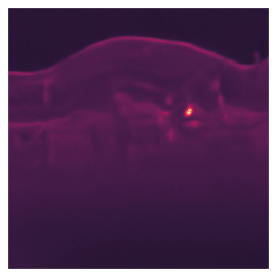

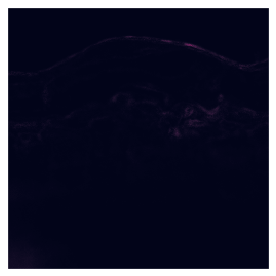

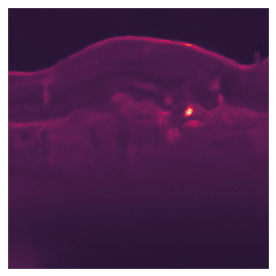

mc_dropout_den_oct_2d_1


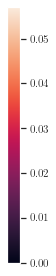

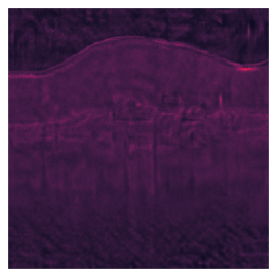

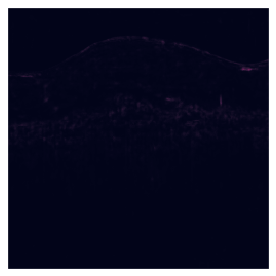

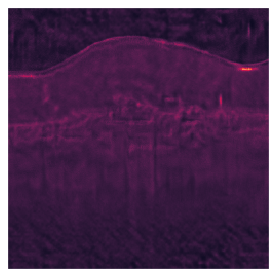

sgld_den_oct_uncert


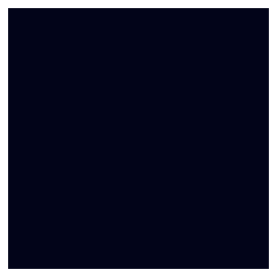

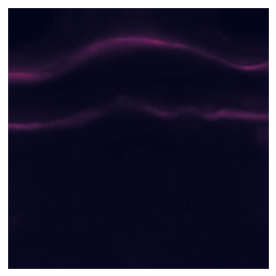

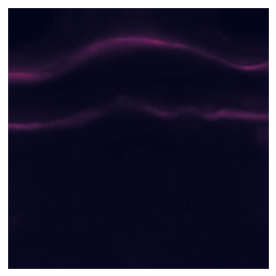

sgld_paper_den_oct_uncert


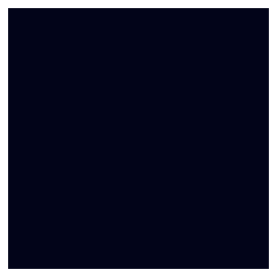

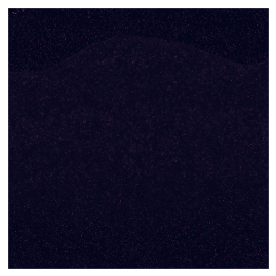

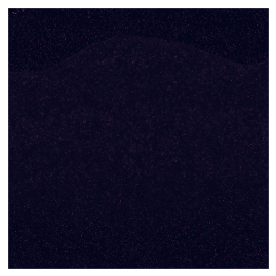

In [7]:
#ale_maps = ale_maps[1:]
#epi_maps = epi_maps[1:]
#uncert_maps = uncert_maps[1:]
_uncerts = np.array([ale_maps[:3], epi_maps[:3], uncert_maps[:3]])
vmin = _uncerts.min()
vmax = _uncerts.max()
for i, (ale, epi, uncert, run) in enumerate(zip(ale_maps, epi_maps, uncert_maps, runs[1:])):
    print(run)
    for u, l in zip([ale, epi, uncert], ['ale', 'epi', 'uncert']):
        #fig, ax = plt.subplots(1,1)
        fig = plt.figure()
        im = plt.imshow(u, vmin=vmin, vmax=vmax)
        #plt.colorbar()
        plt.grid(False)
        plt.yticks([])
        plt.xticks([])
        plt.tight_layout()
        plt.savefig('imgs/%s_%s_same.pdf' % (run, l), bbox_inches='tight')
        plt.show()

        if i == 0 and l == 'uncert':
            fig, ax = plt.subplots(1,1, figsize=fig.get_size_inches())
            plt.colorbar(im, ax=ax)
            ax.remove()
            plt.tight_layout()
            plt.savefig('imgs/same_%s_colorbar' % run, bbox_inches='tight')

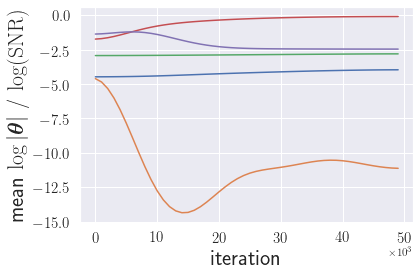

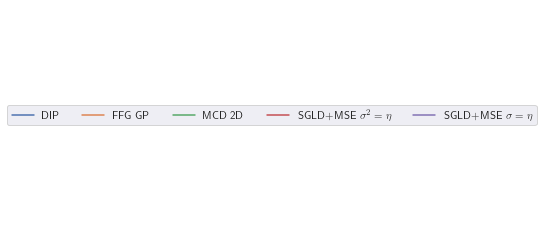

In [8]:
ys = [params[run]['mean'] for run in runs]

xs = [np.array([_ for _ in range(len(params[run]['mean']))]) * (len(losses[run]['mse']) / len(params[run]['mean'])) for run in runs]

np_plot(xs, ys, labels=labels, ylabel=r'mean $\log|\bm{\theta}|$ / $\log(\textrm{SNR})$', 
        xtlf='sci', separate_legend=True, path='imgs/%s_means.pdf' % to_compare)

No handles with labels found to put in legend.


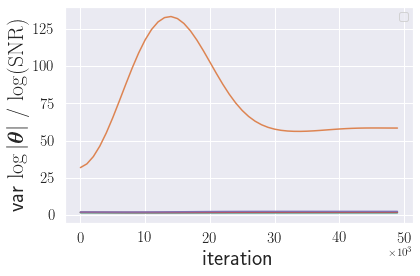

In [9]:
ys = [params[run]['var'] for run in runs]

xs = [np.array([_ for _ in range(len(params[run]['var']))]) * (len(losses[run]['mse']) / len(params[run]['var'])) for run in runs]

np_plot(xs, ys, labels=None, ylabel=r'var $\log|\bm{\theta}|$ / $\log(\textrm{SNR})$', 
        xtlf='sci', path='imgs/%s_vars.pdf' % to_compare)#, xlim=[0,len(losses[runs[0]]['mse'])])#, ytlf='sci', ylim=[-0.001,0.026])

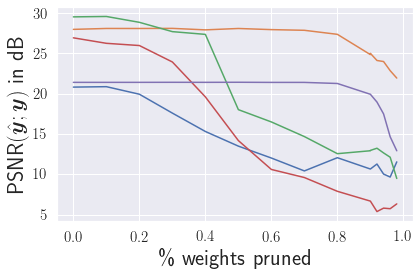

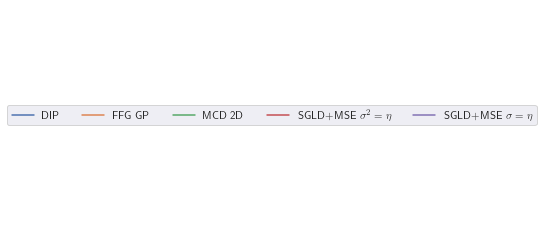

In [10]:
ys = [psnrs[run]['pruning'] for run in runs]
xs = [pruning_range for _ in runs]
np_plot(xs, ys, labels=labels, ylabel=r'PSNR$(\hat{\bm{y}};\bm{y})$ in dB', xlabel=r'\% weights pruned', sigma=0, 
        path='imgs/%s_pruned.pdf' % to_compare, separate_legend=True)#, path='pruned_weights.pdf')

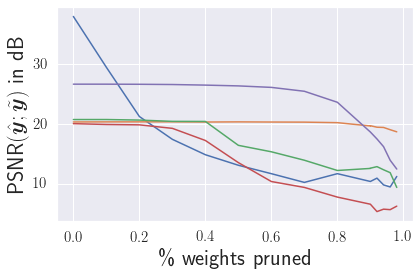

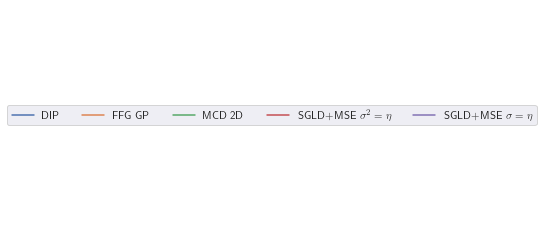

In [11]:
ys = [psnrs[run]['pruning_noisy'] for run in runs]
xs = [pruning_range for _ in runs]
np_plot(xs, ys, labels=labels, ylabel=r'PSNR$(\hat{\bm{y}};\tilde{\bm{y}})$ in dB', xlabel=r'\% weights pruned', sigma=0, 
        path='imgs/%s_pruned_noisy.pdf' % to_compare, separate_legend=True)#, path='pruned_weights.pdf')

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


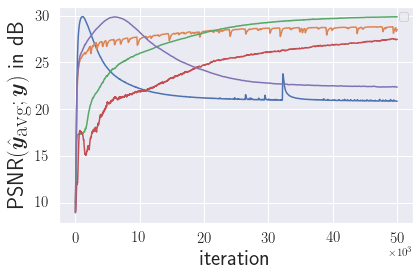

In [12]:
ys = [psnrs[run]['gt\_sm'] for run in runs]
xs = [range(len(psnrs[run]['gt\_sm'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'PSNR$(\hat{\bm{y}}_{\textrm{avg}};\bm{y})$ in dB', xtlf='sci', 
        path='imgs/%s_psnrs.pdf' % to_compare)

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


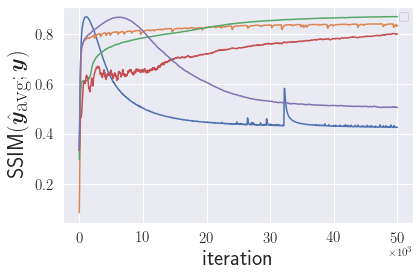

In [13]:
ys = [ssims[run]['gt\_sm'] for run in runs]
xs = [range(len(ssims[run]['gt\_sm'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'SSIM$(\hat{\bm{y}}_{\textrm{avg}};\bm{y})$', xtlf='sci', 
        path='imgs/%s_ssims.pdf' % to_compare)

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


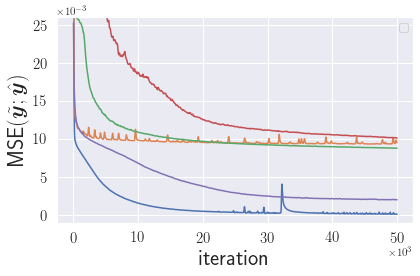

In [14]:
ys = [losses[run]['mse'] for run in runs]
xs = [range(len(losses[run]['mse'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'MSE$(\tilde{\bm{y}};\hat{\bm{y}})$', sigma=50, ytlf='sci', xtlf='sci', 
        ylim=[-0.001,0.026], path='imgs/%s_mses.pdf' % to_compare)

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


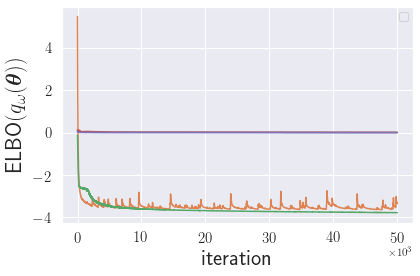

In [15]:
ys = [losses[run]['elbo'] for run in runs]
xs = [range(len(losses[run]['elbo'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'ELBO$(q_{\omega}(\bm{\theta}))$', xtlf='sci', #ylim=[-6.8, 0.5], 
        path='imgs/%s_elbos.pdf' % to_compare)

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


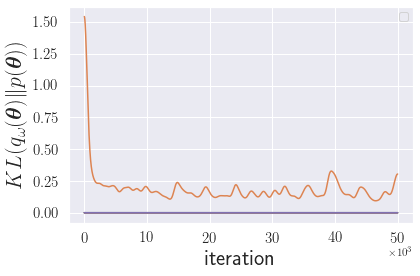

In [16]:
ys = [losses[run]['kl'] for run in runs]
xs = [range(len(losses[run]['kl'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'$KL(q_{\omega}(\bm{\theta})\|p(\bm{\theta}))$', 
        sigma=400, xtlf='sci', #ylim=[-0.1, 1.4], 
        path='imgs/%s_kls.pdf' % to_compare)

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


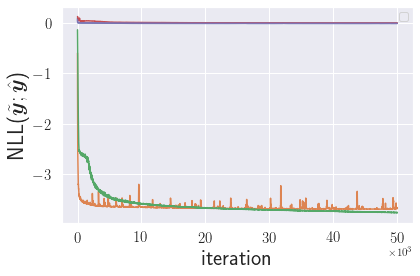

In [17]:
ys = [losses[run]['nll'] for run in runs]
xs = [range(len(losses[run]['nll'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'NLL($\tilde{\bm{y}};\hat{\bm{y}}$)', xtlf='sci', 
        path='imgs/%s_nlls.pdf' % to_compare)

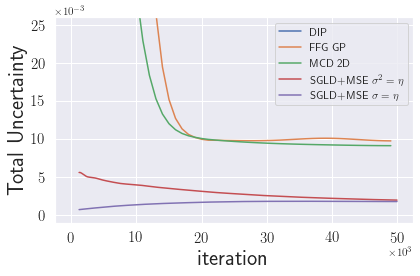

In [18]:
#ys = [uncerts[run]['uncert'] for run in runs]
#xs = np.array([range(len(uncerts[run]['uncert'])) for run in runs]) * (len(losses[runs[0]]['mse']) / len(uncerts[runs[0]]['uncert']))

ys = [uncerts[run]['uncert'] for run in runs]

xs = [np.array([_ for _ in range(len(uncerts[run]['uncert']))]) * (len(losses[run]['mse']) / len(uncerts[run]['uncert'])) for run in runs]

np_plot(xs, ys, labels=labels, ylabel=r'Total Uncertainty', 
        xtlf='sci', ytlf='sci', ylim=[-0.001,0.026], path='imgs/%s_uncerts.pdf' % to_compare)

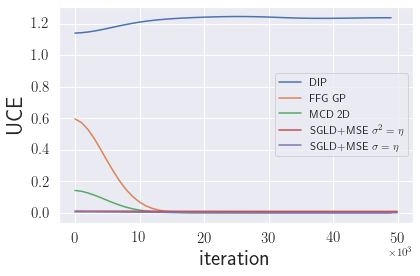

In [19]:
#ys = [uncerts[run]['uncert'] for run in runs]
#xs = np.array([range(len(uncerts[run]['uce'])) for run in runs]) * (len(losses[runs[0]]['mse']) / len(uncerts[runs[0]]['uce']))
ys = [uncerts[run]['uce'] for run in runs]

xs = [np.array([_ for _ in range(len(uncerts[run]['uce']))]) * (len(losses[run]['mse']) / len(uncerts[run]['uce'])) for run in runs]

np_plot(xs, ys, labels=labels, ylabel=r'UCE', 
        xtlf='sci', path='imgs/%s_uces.pdf' % to_compare)#, ytlf='sci', ylim=[-0.001,0.026])

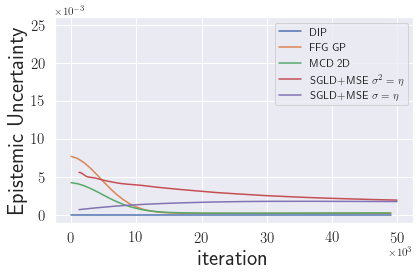

In [20]:
#ys = [uncerts[run]['epi'] for run in runs]
#xs = np.array([range(len(uncerts[run]['epi'])) for run in runs]) * (len(losses[runs[0]]['mse']) / len(uncerts[runs[0]]['epi']))
ys = [uncerts[run]['epi'] for run in runs]

xs = [np.array([_ for _ in range(len(uncerts[run]['epi']))]) * (len(losses[run]['mse']) / len(uncerts[run]['epi'])) for run in runs]

np_plot(xs, ys, labels=labels, ylabel=r'Epistemic Uncertainty', 
        xtlf='sci', ytlf='sci', ylim=[-0.001,0.026], path='imgs/%s_epis.pdf' % to_compare)

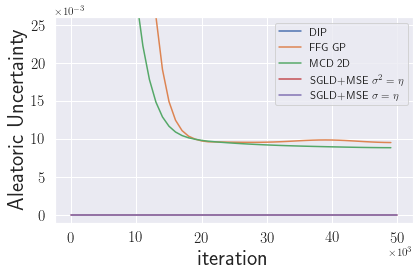

In [21]:
#ys = [uncerts[run]['ale'] for run in runs]
#xs = np.array([range(len(uncerts[run]['ale'])) for run in runs]) * (len(losses[runs[0]]['mse']) / len(uncerts[runs[0]]['ale']))
ys = [uncerts[run]['ale'] for run in runs]

xs = [np.array([_ for _ in range(len(uncerts[run]['ale']))]) * (len(losses[run]['mse']) / len(uncerts[run]['ale'])) for run in runs]

np_plot(xs, ys, labels=labels, ylabel=r'Aleatoric Uncertainty', 
        xtlf='sci', ytlf='sci', ylim=[-0.001,0.026], path='imgs/%s_ales.pdf' % to_compare)

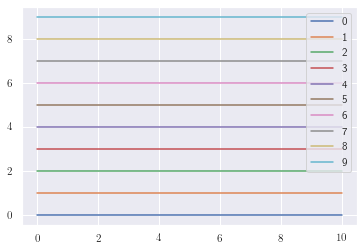

In [22]:
for i in range(10):
    plt.plot(np.linspace(0, 10, 100), np.ones(100) * i, label=i)
plt.legend()
plt.show()